# Backpropagation Lab





In [3]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import copy
import math

## 1. Correctly implement and submit your own code for the backpropagation algorithm. 

## Code requirements 
- Ability to create a network structure with at least one hidden layer and an arbitrary number of nodes.
- Random weight initialization with small random weights with 0 mean. Remember that every hidden and output node should have its own bias weight.
- Use stochastic training updates: update weights after each training instance (i.e. not batch)
- Implement a validation set based stopping criterion. Keep your *BSSF* and once you go *w* epochs with no improvement (e.g. 10) then use the weights from the *BSSF*.
- Option to include a momentum term

Use your Backpropagation algorithm to solve the Debug data. We provide you with several parameters, and you should be able to replicate our results every time. When you are confident it is correct, run your script on the Evaluation data with the same parameters, and print your final weights.

In [357]:
from prompt_toolkit.application import current
from os import sendfile
class MLP(BaseEstimator,ClassifierMixin):

    def __init__(self,lr=.1, momentum=0, shuffle=True,hidden_layer_widths=None):
        """ Initialize class with chosen hyperparameters.

        Args:
            lr (float): A learning rate / step size.
            shuffle(boolean): Whether to shuffle the training data each epoch. DO NOT SHUFFLE for evaluation / debug datasets.
            momentum(float): The momentum coefficent 
        Optional Args (Args we think will make your life easier):
            hidden_layer_widths (list(int)): A list of integers which defines the width of each hidden layer if hidden layer is none do twice as many hidden nodes as input nodes. (and then one more for the bias node)
            For example: input width 1, then hidden layer will be 3 nodes
        Example:
            mlp = MLP(lr=.2,momentum=.5,shuffle=False,hidden_layer_widths = [3,3]),  <--- this will create a model with two hidden layers, both 3 nodes wide
        """
        self.hidden_layer_widths = hidden_layer_widths
        self.lr = lr
        self.momentum = momentum
        self.epochs_count = 0
        self.training_accuracies = []
        self.training_MSEs = []
        self.validation_accuracies = []
        self.validation_MSEs = []
        self.test_accuracies = []
        self.test_MSEs = []
        self.shuffle = shuffle
        self.missclassifications = []


    def fit(self, X, y, initial_weights=None, Deterministic=None, weights_given=False, train_test_ratio=0.80, train_validation_ratio=0.85, debugger=False):
        """ Fit the data; run the algorithm and adjust the weights to find a good solution

        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
            y (array-like): A 2D numpy array with the training targets
        Optional Args (Args we think will make your life easier):
            initial_weights (array-like): allows the user to provide initial weights
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)

        """

        # Initialize weights if not given
        self.weights = self.initialize_weights(X.shape[1], y.shape[1]) if not weights_given else initial_weights
        if debugger: print("Starting Weights:",self.weights)

        # Allow the model to train for a maximum of 1000 epochs if deterministic ephoc number is not given
        set_num_epochs = True
        if Deterministic == None:
          set_num_epochs = False
          Deterministic = 1000
          best_mse_so_far = float("inf")
          epochs_w_o_improvement = 0
          # Divide the data into training and test sets (default 80%-20% split)
          X, y, self.test_data, self.test_targets = self.set_split(X, y, train_test_ratio)

          # Divide the training set into training and validation sets (default 85%-15% split)
          X, y, self.validation_data, self.validation_targets = self.set_split(X, y, train_validation_ratio)

          self.training_data, self.training_targets = X, y
          self.n_outputs = y.shape[1]

          # Record baseline accuracy and MSE data
          training_accuracy, training_mse = self.score(X, y)
          self.training_accuracies.append([0, training_accuracy])
          self.training_MSEs.append([0, training_mse])

          val_accuracy, val_mse = self.score(self.validation_data, self.validation_targets)
          self.validation_accuracies.append([0, val_accuracy])
          self.validation_MSEs.append([0, val_mse])

          test_accuracy, test_mse = self.score(self.test_data, self.test_targets)
          self.test_accuracies.append([0, test_accuracy])
          self.test_MSEs.append([0, test_mse])

        # Train model on data for specified # of epochs, or a max of 1000 epochs if unspecified
        # Early stopping requires 5 epochs to pass with no improvement on the test set 
        prev_delta_w = []
        for epoch in range(Deterministic):
          if debugger: print("Starting an epoch")
          # Keep track of previous weights to revert back to if there is no improvement for the next 5 epochs
          epoch_starting_weights = self.weights.copy()

          # Shuffle data if required, each epoch
          if self.shuffle:
            self.training_data, self.training_targets = self._shuffle_data(X, y)
          else: 
            self.training_data, self.training_targets = X, y

          # Train model on data, row by row, updating weight vectors by stochastic gradient descent
          i = 0
          length = np.shape(self.training_data)[0]
          while i < length:
            # For each node in each hidden layer, dot product all inputs and bias by their weights and sigmoid func them, 
            # keeping track of layer outputs for future weight updates
            current_layer = self.training_data[i]
            outputs = []
            outputs.append( np.append(self.training_data[i].tolist(), [1.0]) )
            for j in range(len(self.hidden_layer_widths)):
              current_layer = np.append(current_layer, np.array([1.0]))
              nets = [np.dot(current_layer, np.transpose(self.weights[j][k])) for k in range(self.hidden_layer_widths[j])]
              if debugger: print("Nets:",nets)
              current_layer = [1.0/(1.0+np.exp(-nets[k])) for k in range(len(nets))]
              if debugger: print("Zs:",current_layer)
              outputs.append( np.append(current_layer, [1.0]) )
              if debugger: print("made it a past a layer")
            # Calculate final outputs for this line of data by taking the dot product of the last hidden layer's outputs 
            # and the final layer of weights, then putting them through a sigmoid activation function
            current_layer = np.append(current_layer, np.array([1.0]))
            nets = [np.dot(current_layer, np.transpose(self.weights[-1][k])) for k in range(y.shape[1])]
            if debugger: print("Final nets:", nets)
            current_layer = [1.0/(1.0+np.power(np.e, -nets[k])) for k in range(len(nets))]
            outputs.append(current_layer)
            if debugger: print("Output: ", current_layer)
            if debugger: print("OutputVec:", outputs)

            # Adjust weights by stochastic gradient descent
            delta_w = []

            # Calculate hidden and output node errors
            # Error matrix contains all nodes except input layer, since those errors aren't needed for back propogation 
            errors = []
            for j in range(1,len(outputs)):
              errors.append( [outputs[j][k] for k in range( len(outputs[j]) )] )
              
            errors[-1] = [(self.training_targets[i][j] - outputs[-1][j]) * outputs[-1][j] * (1 - outputs[-1][j]) for j in range( len(errors[-1]) ) ]
            if debugger: print("Calc'd output nodes' errors")
            # j is errors matrix row, starting from 2nd to last and moving to the beginning
            for j in range(len(errors) - 2, -1, -1):
              # k is hidden layer node we're calculating error for
              for k in range(len(errors[j]) - 1):
                if j == len(errors) - 2: errors[j][k] = errors[j][k] * (1 - errors[j][k]) * np.sum( [ self.weights[j+1][m][k] * errors[j+1][m] for m in range( len(errors[j+1]) ) ] ) # f'(net_j) * SUM( outgoing_weights * destination_errors )
                else: errors[j][k] = errors[j][k] * (1 - errors[j][k]) * np.sum( [ self.weights[j+1][k][m] * errors[j+1][m] for m in range( len(errors[j+1]) - 1) ] )                 # f'(net_j) * SUM( outgoing_weights * destination_errors )
                if debugger: print("Calc'd 1 hidden node error")
            if debugger: print("Errors:", errors)
            if debugger: print("Weights:",self.weights)
            if debugger: print("delta_w's:", delta_w)

            # j is row within weights
            for j in range(len(self.weights)):
              row_delta_w = []
              # k is index of destination node
              for k in range( len(self.weights[j]) ):
                segment_delta_w = []
                # Only apply momentum if we have previous delta_w's to draw on ( > 0)
                if self.epochs_count == 0 and i == 0: segment_delta_w.append( [ self.lr * errors[j][k] * outputs[j][m]  for m in range( len(outputs[j]) ) ] )
                else: segment_delta_w.append( [ self.lr * errors[j][k] * outputs[j][m] + (self.momentum * prev_delta_w[j][k][0][m]) for m in range( len(outputs[j]) ) ] )
                row_delta_w.append(segment_delta_w)
                #if debugger: print("Calc'd a set of delta_w's", segment_delta_w)
              delta_w.append(row_delta_w)
            if debugger: print("Deltas:",delta_w)
            if debugger: print("Weights:",self.weights)

            # Apply delta_w's to weights
            # j is a row of weights
            for j in range(len(self.weights)):
              # k is a segment of a row of weights
              for k in range( len(self.weights[j]) ):
                # m is a weight in a segment of a row of weights
                for m in range(len(self.weights[j][k])):
                  self.weights[j][k][m] = self.weights[j][k][m] + delta_w[j][k][0][m]
            if debugger: print("Updated Weights:",self.weights)
            if debugger: print("Previous deltas:",prev_delta_w)
            # Copy delta_w to prev_delta_w to make seperate objects
            prev_delta_w = delta_w
            if debugger: print("Previous deltas now:",prev_delta_w)

            # Increment to next row in training set
            i += 1

          # Stopping Criteria: if no improvement in mean squared error (MSE) is recorded for 5 consecutive epochs, revert to weights from 5 epochs ago, halt training
          # Only check this if preset number of epochs was not specified
          if set_num_epochs == False:
            val_accuracy, val_mse = self.score(self.validation_data, self.validation_targets)
            if val_mse >= best_mse_so_far:
              epochs_w_o_improvement += 1
              if epochs_w_o_improvement == 1:
                reverted_weights = epoch_starting_weights
            else:
              epochs_w_o_improvement = 0
              best_mse_so_far = val_mse

            # Record error data for this epoch
            training_accuracy, training_mse = self.score(X, y)
            self.training_accuracies.append([self.epochs_count+1, training_accuracy])
            self.training_MSEs.append([self.epochs_count+1, training_mse])

            self.validation_accuracies.append([self.epochs_count+1, val_accuracy])
            self.validation_MSEs.append([self.epochs_count+1, val_mse])

            test_accuracy, test_mse = self.score(self.test_data, self.test_targets)
            self.test_accuracies.append([self.epochs_count+1, test_accuracy])
            self.test_MSEs.append([self.epochs_count+1, test_mse])


          self.epochs_count += 1
          if set_num_epochs == False and epochs_w_o_improvement == 5:
            # Revert back to weights from 5 epochs ago if no improvement recorded for 5 epochs
            self.weights = reverted_weights
            if debugger: print("reverted weights")
            break
          if debugger: print("made it past an epoch")

        return self

    def predict(self, X):
        """ Predict all classes for a dataset X
        Args:
            X (array-like): A 2D numpy array with the training data, excluding targets
        Returns:
            array, shape (n_samples,)
                Predicted target values per element in X.
        """
        classes = []
        i = 0
        while i < X.shape[0]:
          # For each node in each hidden layer, dot product all inputs and bias by their weights and sigmoid func them
          current_layer = X[i]
          for j in range(len(self.hidden_layer_widths)):
            current_layer = np.append(current_layer, np.array([1.0]))
            nets = [ np.dot(current_layer, np.transpose(self.weights[j][k])) for k in range(self.hidden_layer_widths[j]) ]
            current_layer = [ 1.0/(1.0+np.exp(-nets[k])) for k in range( len(nets) ) ]
          # Calculate final outputs for this line of data by taking the dot product of the last hidden layer's outputs 
          # and the final layer of weights, then putting them through a sigmoid activation function
          current_layer = np.append(current_layer, np.array([1.0]))
          nets = [ np.dot(current_layer, np.transpose(self.weights[-1][k])) for k in range(self.n_outputs) ]
          current_layer = [1.0/(1.0+np.power(np.e, -nets[k])) for k in range(len(nets))]
          classes.append(current_layer)

          i += 1

        return classes

    def score(self, X, y):
        """ Return accuracy of model on a given dataset. Must implement own score function.

        Args:
            X (array-like): A 2D numpy array with data, excluding targets
            y (array-like): A 2D numpy array with targets

        Returns:
            score : float
                Mean accuracy of self.predict(X) wrt. y.
        """
        predictions = self.predict(X)
        
        accuracy = np.mean( [ 1 if all( [ True if abs(y[i][j] - predictions[i][j]) < 0.5 else False for j in range( len(y[i]) ) ] ) else 0 for i in range(np.shape(y)[0]) ] )
        mse = np.mean( [ np.sum( [ np.power( (y[i][j] - predictions[i][j]), 2) for j in range( len(y[i]) ) ] ) for i in range(np.shape(y)[0]) ] )
        
        return float("{:.2f}".format( accuracy )), float("{:.2f}".format( mse ))

    def initialize_weights(self, n_inputs, n_outputs):
        """ Initialize weights for MLP. Don't forget the bias!

        Returns:

        """
        weights = []
        min_val, max_val = -1, 1
        range_size = max_val - min_val

        if not self.hidden_layer_widths == None:
          # Add weights between inputs and first hidden row
          node_weights = []
          for a in range(self.hidden_layer_widths[0]):
            node_weights.append( [ np.random.rand() * range_size + min_val for i in range(n_inputs + 1) ] )
          weights.append(node_weights)

          # Add weights between hidden rows
          for i in range(len(self.hidden_layer_widths)-1):
            node_weights = []
            for a in range(self.hidden_layer_widths[i+1]):
              node_weights.append( [ np.random.rand() * range_size + min_val for j in range(self.hidden_layer_widths[i]+1) ] )
            weights.append(node_weights)
          # Add weights between last hidden row and outputs
          node_weights = []
          for a in range(n_outputs):
              node_weights.append( [ np.random.rand() * range_size + min_val for b in range(self.hidden_layer_widths[-1]+1) ] )
          weights.append(node_weights)

        # If no hidden layers, add weights between input layer and output layer only
        else:
          # Add weights between inputs and outputs
          node_weights = []
          for a in range(n_outputs):
            node_weights.append( [ np.random.rand() * range_size + min_val for b in range(n_inputs+1)] )
          weights.append(node_weights)

        return weights

    def set_split(self, X, y, set_split_ratio):
      n_outputs = y.shape[1]

      X_shuffled, y_shuffled = self._shuffle_data(X, y)
      y_shuffled = y_shuffled.reshape(-1,y.shape[1])

      composite = np.concatenate((X_shuffled, y_shuffled), 1)
      rowC = np.shape(composite)[0]
      splitPos = int(set_split_ratio * rowC)
      larger_set = composite[:splitPos, :]
      smaller_set = composite[splitPos:, :]
      
      return larger_set[:, :-n_outputs], larger_set[:,-n_outputs:].reshape(-1,n_outputs), smaller_set[:, :-n_outputs], smaller_set[:,-n_outputs:].reshape(-1,n_outputs)

    def _shuffle_data(self, X, y):
        """ Shuffle the data! This _ prefix suggests that this method should only be called internally.
            It might be easier to concatenate X & y and shuffle a single 2D array, rather than
             shuffling X and y exactly the same way, independently.
        """
        n_outputs = y.shape[1]
        composite = np.concatenate((X, y), 1)
        rowC = np.shape(composite)[0]
        shuffled = np.zeros(np.shape(composite))
        for i in range(0, rowC):
          rand = np.random.randint(np.shape(composite)[0])
          shuffled[i][:] = composite[rand][:]
          composite = np.delete(composite, rand, 0)
        return shuffled[:,:-n_outputs], shuffled[:,-n_outputs:]

    ### Not required by sk-learn but required by us for grading. Returns the weights.
    def get_weights(self):
        return self.weights

    def get_epochs_count(self):
      return self.epochs_count

    def get_training_accuracy(self):
      return self.best_training_accuracy

    def get_test_accuracy(self):
      return self.best_test_accuracy

    def get_missclassifications(self):
      return self.missclassifications

    def get_training_accuracy_data(self):
      return self.training_accuracies

    def get_training_MSE_data(self):
      return self.training_MSEs

    def get_validation_accuracy_data(self):
      return self.validation_accuracies

    def get_validation_MSE_data(self):
      return self.validation_MSEs

    def get_test_accuracy_data(self):
      return self.test_accuracies

    def get_test_MSE_data(self):
      return self.test_MSEs

## 1.1 Debug and Evaluation

Debug your model using the following parameters:

Learning Rate = 0.1\
Momentum = 0.5\
Deterministic = 10 [This means run it 10 epochs and should be the same everytime you run it]\
Shuffle = False\
Validation size = 0\
Initial Weights = All zeros\
Hidden Layer Widths = [4]

---

### 1.1.1 (20%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff)


Expected Results for Binary Classification (i.e. 1 output node): [debug_bp_0.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_0.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 & -8.81779797\text{e}-05 \\ 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 & 7.82757731\text{e}-04 \\ -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 & -3.94353645\text{e}-03 \end{bmatrix}$$
                                             
$$ \text{Layer 2} = \begin{bmatrix} -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.01060888 \\ -0.02145495 \end{bmatrix}$$


Expected Results for One Hot Vector Classification (i.e. 2 output nodes): [debug_bp_2outs.csv](https://github.com/cs472ta/CS472/blob/master/debug_solutions/debug_bp_2outs.csv) 

$$ \text{Layer 1} = \begin{bmatrix} -0.00018149 & -0.00018149 & -0.00018149 & -0.00018149 \\ 0.00157468 & 0.00157468 & 0.00157468 & 0.00157468 \\ -0.00788218 & -0.00788218 & -0.00788218 & -0.00788218 \end{bmatrix}$$
                          
$$ \text{Layer 2} = \begin{bmatrix} 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.01050642 & -0.01050642 \\ 0.02148778 & -0.02148778 \end{bmatrix}$$

Based on how you index your weights, they may not be in the exact order or shape as our two examples above, but the weight values should be the same.

In [358]:
# Load debug data
!curl -o debug_data.arff "https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/linsep2nonorigin.arff"
debug_data = np.array(arff.loadarff('debug_data.arff')[0].tolist(), dtype=np.double)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   197  100   197    0     0   4104      0 --:--:-- --:--:-- --:--:--  4104


In [359]:
X_debug, y_debug = debug_data[:,:-1], debug_data[:,-1].reshape(-1,1)
X_basic, y_basic = np.array([[0.9, 0.6]]), np.array([[0]])

# Create one-hot encoded version of debug outputs
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_debug)
OneHotEncoder(handle_unknown='ignore')
y_one_hot = enc.transform(y_debug).toarray().reshape(-1,2)

In [360]:
# Train on debug data
myMLP_debug = MLP(lr=.1, momentum=0.5, shuffle=False, hidden_layer_widths=[4])
myMLP_debug_one_hot = MLP(lr=.1, momentum=0.5, shuffle=False, hidden_layer_widths=[4])

# Create 0 weights vectors
zero_weights_debug = [ [ [0.0, 0.0, 0.0], 
                         [0.0, 0.0, 0.0], 
                         [0.0, 0.0, 0.0], 
                         [0.0, 0.0, 0.0] ],
                       [ [0.0, 0.0, 0.0, 0.0, 0.0] ] ]

zero_weights_debug_one_hot = [ [ [0.0, 0.0, 0.0], 
                                 [0.0, 0.0, 0.0], 
                                 [0.0, 0.0, 0.0], 
                                 [0.0, 0.0, 0.0] ],
                               [ [0.0, 0.0, 0.0, 0.0, 0.0],
                                 [0.0, 0.0, 0.0, 0.0, 0.0] ] ]

# Train on debug data
myMLP_debug.fit(X_debug, y_debug, initial_weights=zero_weights_debug, weights_given=True, Deterministic=10)
myMLP_debug_one_hot.fit(X_debug, y_one_hot, initial_weights=zero_weights_debug_one_hot, weights_given=True, Deterministic=10)

# Print weights
print("Binary Weights:",myMLP_debug.get_weights())
print("One-Hot Weights:",myMLP_debug_one_hot.get_weights())

Binary Weights: [[[-8.817797972713649e-05, 0.0007827577311041648, -0.003943536449023682], [-8.817797972713649e-05, 0.0007827577311041648, -0.003943536449023682], [-8.817797972713649e-05, 0.0007827577311041648, -0.003943536449023682], [-8.817797972713649e-05, 0.0007827577311041648, -0.003943536449023682]], [[-0.010608880220732603, -0.010608880220732603, -0.010608880220732603, -0.010608880220732603, -0.02145495347143381]]]
One-Hot Weights: [[[-0.00018149431827609432, 0.0015746849754383438, -0.00788218446362105], [-0.00018149431827609432, 0.0015746849754383438, -0.00788218446362105], [-0.00018149431827609432, 0.0015746849754383438, -0.00788218446362105], [-0.00018149431827609432, 0.0015746849754383438, -0.00788218446362105]], [[0.010506417199621783, 0.010506417199621783, 0.010506417199621783, 0.010506417199621783, 0.0214877791309856], [-0.01050641719962178, -0.01050641719962178, -0.01050641719962178, -0.01050641719962178, -0.021487779130985585]]]


*Discussion*

Some major learning moments that I had while building this MLP algorithm included when I could not figure out what data structure to use for the weights, and when my debug weights were slightly off because I was not using momentum for the entire first epoch, rather than just the first row of the first epoch. For the weights data structure, I first tried a list of numpy arrays, then a list of lists, then a dictionary of lists, then finally I went back to a list of lists as it was the only one I could get working. As for my momentum issue, I had built the algorithm to skip adding momentum if there was no previous weight delta vector available (on the very first row of training). My mistake was that I only checked if epoch count was 0 and failed to check if the training data row was also 0, meaning I was skipping momentum for the entire first epoch. Correcting that fixed my issue immediately.

### 1.1.2 (20%) Evaluation

Evaluate your model using the SAME parameters as above for the Debug data set

We will evaluate your model based on the weights your code prints after training on the [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff)

In [361]:
# Load evaluation data
!curl -o eval_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/data_banknote_authentication.arff
eval_data = np.array(arff.loadarff('eval_data.arff')[0].tolist(), dtype=np.double)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 46685  100 46685    0     0   314k      0 --:--:-- --:--:-- --:--:--  314k


In [362]:
X_eval, y_eval = eval_data[:,:-1], eval_data[:,-1].reshape(-1,1)
# Create one-hot-encoded version of evaluation targets
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_eval)
OneHotEncoder(handle_unknown='ignore')
y_eval_one_hot = enc.transform(y_eval).toarray().reshape(-1,2)

zero_weights_eval = [ [ [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0],
                        [0.0, 0.0, 0.0, 0.0, 0.0] ],
                      [ [0.0, 0.0, 0.0, 0.0, 0.0] ] ]

zero_weights_eval_one_hot = [ [ [0.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 0.0] ],
                              [ [0.0, 0.0, 0.0, 0.0, 0.0],
                                [0.0, 0.0, 0.0, 0.0, 0.0] ] ]

In [363]:
# Train on evaluation data
myMLP_eval = MLP(lr=.1, momentum=0.5, shuffle=False, hidden_layer_widths=[4])
myMLP_eval_one_hot = MLP(lr=.1, momentum=0.5, shuffle=False, hidden_layer_widths=[4])
# Have your code execute and print your weights here. Do not enter the weights by hand.
myMLP_eval.fit(X_eval, y_eval, initial_weights=zero_weights_eval, weights_given=True, Deterministic=10)
myMLP_eval_one_hot.fit(X_eval, y_eval_one_hot, initial_weights=zero_weights_eval_one_hot, weights_given=True, Deterministic=10)
print("Binary Weights:",myMLP_eval.get_weights())
print("One-Hot Weights:",myMLP_eval_one_hot.get_weights())

Binary Weights: [[[1.3093236576947886, 0.8060103325551435, 0.9274418668138541, 0.22165293863559846, -1.4531373130727117], [1.3093236576947886, 0.8060103325551435, 0.9274418668138541, 0.22165293863559846, -1.4531373130727117], [1.3093236576947886, 0.8060103325551435, 0.9274418668138541, 0.22165293863559846, -1.4531373130727117], [1.3093236576947886, 0.8060103325551435, 0.9274418668138541, 0.22165293863559846, -1.4531373130727117]], [[-1.8851244332958723, -1.8851244332958723, -1.8851244332958723, -1.8851244332958723, 4.57969955214528]]]
One-Hot Weights: [[[1.6382872050704225, 1.0961224948663668, 1.2344759398924885, 0.3926948682935854, -2.093161510270473], [1.6382872050704225, 1.0961224948663668, 1.2344759398924885, 0.3926948682935854, -2.093161510270473], [1.6382872050704225, 1.0961224948663668, 1.2344759398924885, 0.3926948682935854, -2.093161510270473], [1.6382872050704225, 1.0961224948663668, 1.2344759398924885, 0.3926948682935854, -2.093161510270473]], [[1.8169561136874421, 1.8169561

*Discussion*

Testing on the evaluation dataset was very straightforward; the only things I had to do were create a new zero weight vector of the right size for this dataset and plug in all of the same parameters as with the debug dataset

## 2. (10%) Backpropagation on the Iris Classification problem.

Train on the [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff). For this and all following experiments, always start with random weights and shuffle the training set before each epoch. You may use your own data shuffling code and random train/test split code or use scikit-learn versions if you prefer.

Parameters:
- One layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use a random 80/20 split of the data for the training/test set.
- Use a learning rate of 0.1
- Use a validation set (10-15% of the training set is common) taken from the training set for your stopping criteria. 
- Create one graph with MSE (mean squared error, *y*-axis) vs epochs (*x*-axis) for the MSEs on the training set, validation set, and test set. Always include the values at epoch 0 (your initial weights before training)
- Create one graph with classification accuracy (% classified correctly) vs epochs from the training set, validation set, and test set

The results for the different measurables should be shown with a different color, line type, etc. Typical backpropagation accuracies for the Iris data set are 85-95%.

---

In [5]:
# Load iris data
!curl -o iris_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff
iris_data = np.array(arff.loadarff('iris_data.arff')[0].tolist())

X_iris, y_iris = iris_data[:,:-1], iris_data[:,-1].reshape(-1,1)
# Create one-hot-encoded version of iris targets
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_iris)
OneHotEncoder(handle_unknown='ignore')
y_iris_one_hot = enc.transform(y_iris).toarray().reshape(-1,3)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7485  100  7485    0     0  59404      0 --:--:-- --:--:-- --:--:-- 59404


In [365]:
# Iris Classification
myMLP_iris = MLP(lr=.1, momentum=0.5, shuffle=True, hidden_layer_widths=[8])
myMLP_iris.fit(X_iris, y_iris_one_hot, train_test_ratio=0.8, train_validation_ratio=0.85,)

# Use the accuracies/MSEs from your own mlp
train_accuracy_data = np.transpose(myMLP_iris.get_training_accuracy_data())
train_MSE_data = np.transpose(myMLP_iris.get_training_MSE_data())
val_accuracy_data = np.transpose(myMLP_iris.get_validation_accuracy_data())
val_MSE_data = np.transpose(myMLP_iris.get_validation_MSE_data())
test_accuracy_data = np.transpose(myMLP_iris.get_test_accuracy_data())
test_MSE_data = np.transpose(myMLP_iris.get_test_MSE_data())

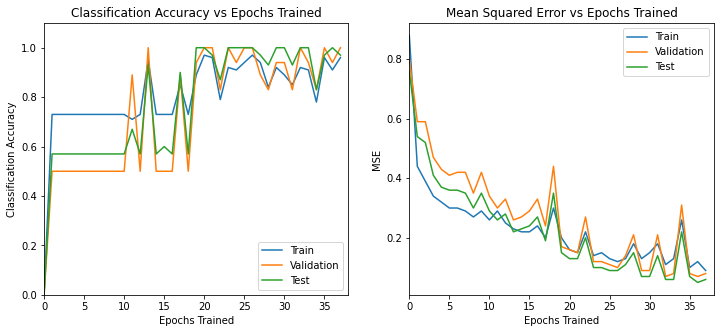

In [366]:
multi, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,5))
ax[0].plot(train_accuracy_data[0][:], train_accuracy_data[1][:], label="Train")
ax[0].plot(val_accuracy_data[0][:], val_accuracy_data[1][:], label='Validation')
ax[0].plot(test_accuracy_data[0][:], test_accuracy_data[1][:], label='Test')
ax[0].title.set_text("Classification Accuracy vs Epochs Trained")
ax[0].set_xlabel("Epochs Trained")
ax[0].set_ylabel("Classification Accuracy")
ax[0].legend(loc="lower right")
ax[0].set_xlim([0, myMLP_iris.get_epochs_count()+1])
ax[0].set_ylim([0, 1.1])

ax[1].plot(train_MSE_data[0][:], train_MSE_data[1][:], label="Train")
ax[1].plot(val_MSE_data[0][:], val_MSE_data[1][:], label='Validation')
ax[1].plot(test_MSE_data[0][:], test_MSE_data[1][:], label='Test')
ax[1].title.set_text("Mean Squared Error vs Epochs Trained")
ax[1].set_xlabel("Epochs Trained")
ax[1].set_ylabel("MSE")
ax[1].legend(loc="upper right")
ax[1].set_xlim([0, myMLP_iris.get_epochs_count()+1])
_ = ax[0].set_ylim(bottom=0)

*Discussion*

A bit of infrastructure needed to be added to my MLP algorithm in order to track both accuracy and mean squared error for each epoch. Once I got that working, creating the charts for them were straightforward. The MSE for my validation and training sets were much for similar to each other than I had expected, which I attribute to low noise levels in the data. This trend is more or less prominent depending on the random weights and shuffle pattern assigned in the learning process.

## 3. Working with Hyperparameters 
### 3.1 (5%) Vowel Dataset - Intuition
- In this section we use the vowel dataset to consider the hyperparameters of learning rate, number of hidden nodes, and momentum.
- Discuss why the vowel data set has lower accuracy than Iris.
- Report both dataset's baseline accuracies. Baseline accuracy is what you would get if the model just outputs the majority class of the data set.
- Consider which of the vowel datasets given input features you should actually use (Train/test, speaker, gender, etc.) and discuss why you chose the ones you did.

Typical backpropagation accuracies for the Vowel data set are above 75%.

*Discuss these items here*

1. The vowel dataset has lower accuracy than iris because there is more noise in the vowel dataset, and because of how many different inputs there are in the vowel dataset. Much more data is required to train the vowel dataset accurately than the iris dataset.

2. Iris Baseline Accuracy:  33% (1/3)

   Vowel Baseline Accuracy: 9% (1/11)

3. I will be omitting "Train or Test," "Speaker Number," and "Sex" when training this model, as an instance's class should be consistent across the range of these inputs when all other inputs hold constant. This means there is no information held in these first three inputs. The others, however, do contain information, which is why inputs "Feature 1" through "Feature 9" are being included.

### 3.2 (10%) Learning Rate
Load the [Vowel Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff)

- Use one layer of hidden nodes with the number of hidden nodes being twice the number of inputs.
- Use random 75/25 splits of the data for the training/test set.
- Use a validation set taken from the training set for your stopping criteria.
- Try some different learning rates (LR). Note that each LR will require a different number of epochs to learn. 
- These hyperparamaters can effect both accuracy and time required for learning. For each LR you test, plot their validations set's MSE (*y*-axis) vs epochs (*x*-axis). Graph 4-5 different LRs and make them different enough to see a difference between them. For stopping use a window of 5 epochs since no change from *BSSF*. 5 is smaller than typical but fine for demonstrating and viewing the concept here. Show the values for the 5 epochs past *BSSF* but put a point at the *BSSF* epoch to make it clear which model you actually choose for each learning rate. Below is an example graph with made up data. We include the Matplotlib code which you may use as a template, but you may use any graphing tools you want.
- Create a table which includes a row for the final chosen model for each LR, showing the LR, # epochs to learn the model, and the final MSE for the training set, validation set, and test set.


In real testing one averages the results of multiple trials per LR with different intitial conditions. That gives more accurate results but is not required for your report.


In [ ]:
# Load vowel data
!curl -o vowel_data.arff https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/vowel.arff
vowel_data = np.transpose(np.array(arff.loadarff('vowel_data.arff')[0].tolist()))
new_vowel_data = np.transpose(vowel_data)

X_vowel, y_vowel = new_vowel_data[:,3:-1], new_vowel_data[:,-1].reshape(-1,1)
# Create one-hot-encoded version of iris targets
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(y_vowel)
OneHotEncoder(handle_unknown='ignore')
y_vowel_one_hot = enc.transform(y_vowel).toarray().reshape(-1,11)

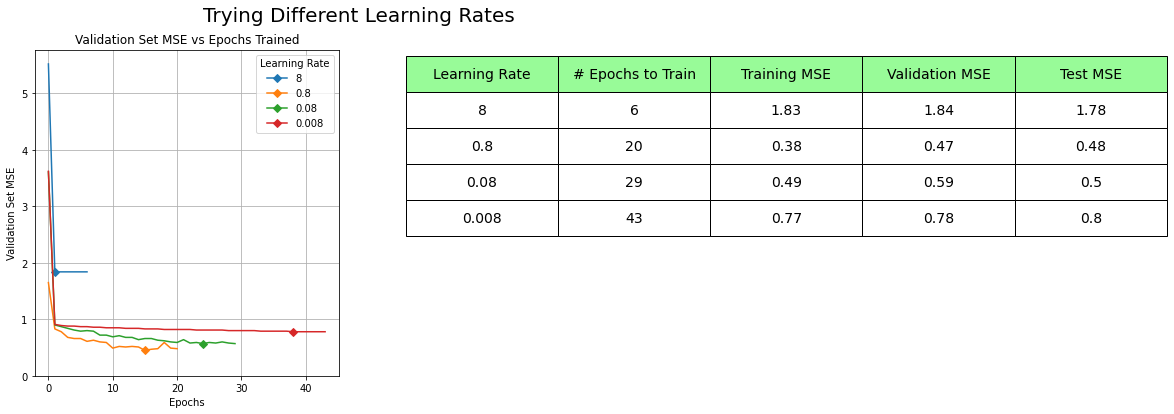

In [380]:
# Train with different learning rates
# NOTE: This takes around 1 minute 40 seconds to complete

def mlp(_lr):
  myMLP_vowel = MLP(lr=_lr, momentum=0.5, shuffle=True, hidden_layer_widths=[20])
  myMLP_vowel.fit(X_vowel, y_vowel_one_hot, train_test_ratio=0.75, train_validation_ratio=0.85)
  tr_mse = np.transpose(myMLP_vowel.get_training_MSE_data())
  v_mse = np.transpose(myMLP_vowel.get_validation_MSE_data())
  te_mse = np.transpose(myMLP_vowel.get_test_MSE_data())
  return myMLP_vowel.get_epochs_count(), tr_mse[1][-5], v_mse[0][:], v_mse[1][:], te_mse[1][-5]

lrs=[8, 0.8, .08, .008]
col_headers = ["Learning Rate", "# Epochs to Train", "Training MSE", "Validation MSE", "Test MSE"]
table_data = []

multi, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
multi.suptitle("Trying Different Learning Rates", fontsize=20)

for lr in lrs:
  e_count, tr_mse, v_mse_x, v_mse_y, te_mse, = mlp(lr) 
  table_data.append([lr, e_count, tr_mse, v_mse_y[-5], te_mse])
  ax[0].plot(v_mse_x, v_mse_y, '-D', markevery=[np.argmin(v_mse_y)], label=lr)

ax[0].legend(title="Learning Rate", loc="upper right")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Validation Set MSE')
ax[0].title.set_text("Validation Set MSE vs Epochs Trained")
ax[0].grid(True)
ax[0].set_ylim(bottom=0)
ax[1].set_axis_off()
table = ax[1].table( cellText = table_data, colLabels = col_headers, colWidths=[0.5]*5, colColours =["palegreen"] * 10, cellLoc ='center', loc ='upper left')
table.set_fontsize(15)
table.scale(1,3)
plt.show()

*Discuss the effect of different learning rates from your graph and table*

With the learning rate set at 8, the model could not learn at all. With 0.8 as the learning rate, the model quickly got to it's minimum MSE for that learning rate, and also happened to achieve the lowest MSE of any of the learning rates, bottoming out at 0.47. The 0.08 learning rate drove the model to a decent validation MSE (0.59), although it did take considerably more epochs to get there than the higher learning rates. 0.008 took by far the most epochs to bottom out, at nearly 40 epochs, and did not achieve an MSE lower than 0.78.

### 3.3 (10%) Number of Hidden Nodes

Using the best LR you discovered, experiment with different numbers of hidden nodes.

- Start with 1 hidden node, then 2, and then double them for each test until you get no more improvement in accuracy. 
- For each number of hidden nodes find the best validation set solution (in terms of validation set MSE).  
- Create both a graph and table just like above, except with # of hidden nodes rather than LR.

In general, whenever you are testing a parameter such # of hidden nodes, test values until no more improvement is found. For example, if 20 hidden nodes did better than 10, you would not stop at 20, but would try 40, etc., until you no longer get improvement.

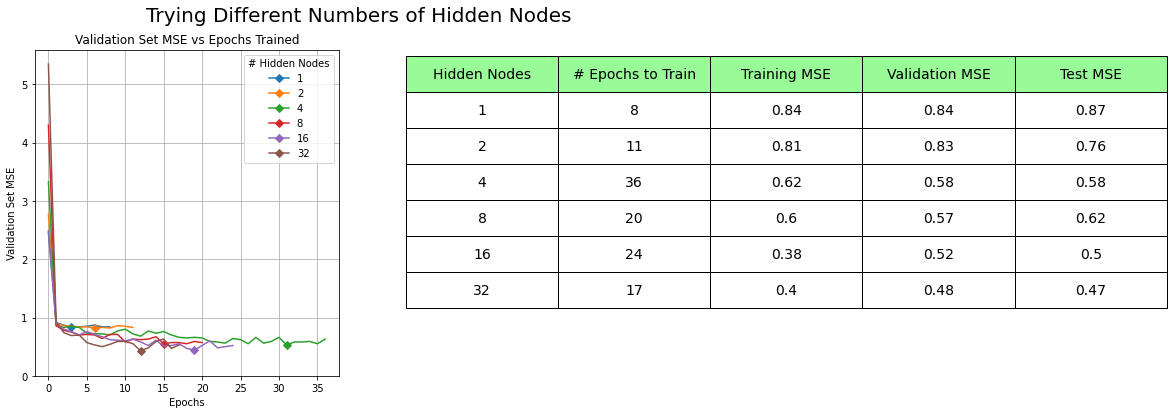

In [382]:
# Train with different numbers of hidden nodes

def mlp(_num_hidden_nodes):
  myMLP_vowel = MLP(lr=0.8, momentum=0.5, shuffle=True, hidden_layer_widths=[_num_hidden_nodes])
  myMLP_vowel.fit(X_vowel, y_vowel_one_hot, train_test_ratio=0.75, train_validation_ratio=0.85)
  tr_mse = np.transpose(myMLP_vowel.get_training_MSE_data())
  v_mse = np.transpose(myMLP_vowel.get_validation_MSE_data())
  te_mse = np.transpose(myMLP_vowel.get_test_MSE_data())
  return myMLP_vowel.get_epochs_count(), tr_mse[1][-5], v_mse[0][:], v_mse[1][:], te_mse[1][-5]

col_headers = ["Hidden Nodes", "# Epochs to Train", "Training MSE", "Validation MSE", "Test MSE"]
table_data = []

multi, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
multi.suptitle("Trying Different Numbers of Hidden Nodes", fontsize=20)
num_hidden_nodes = 1
improving = True
prev_lowest_v_mse = float('inf')
while improving:
  improving = False
  e_count, tr_mse, v_mse_x, v_mse_y, te_mse, = mlp(num_hidden_nodes)
  if v_mse_y[-5] < prev_lowest_v_mse:
    improving = True
    prev_lowest_v_mse = v_mse_y[-5]
    table_data.append([num_hidden_nodes, e_count, tr_mse, v_mse_y[-5], te_mse])
    ax[0].plot(v_mse_x, v_mse_y, '-D', markevery=[np.argmin(v_mse_y)], label=num_hidden_nodes)
    num_hidden_nodes *= 2

ax[0].legend(title="# Hidden Nodes", loc="upper right")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Validation Set MSE')
ax[0].title.set_text("Validation Set MSE vs Epochs Trained")
ax[0].grid(True)
ax[0].set_ylim(bottom=0)
ax[1].set_axis_off()
table = ax[1].table( cellText = table_data, colLabels = col_headers, colWidths=[0.5]*5, colColours =["palegreen"] * 5, cellLoc ='center', loc ='upper left')
table.set_fontsize(15)
table.scale(1,3)
plt.show()

*Discuss the effect of different numbers of hidden nodes from your graph and table* 

The ideal number of hidden nodes varies between 8, 16 and 32, depending on the random weights initially assigned, along with the unique shuffling pattern. 32 appears to be the most ideal number of hidden nodes of that spread, so I will be sticking with that. With 32 nodes, the MSE for training, validation and test sets all seem to be minimized. Ocassionally the exercise will output 4 hidden nodes, while it also will output up to 64 nodes depending on the unique parameters mentioned above.

### 3.4 (10%) Momentum

Try some different momentum terms between 0 and 1 using the best number of hidden nodes and LR from your earlier experiments.

- Create both a graph and table just like above, except with different momentum values rather than LR.

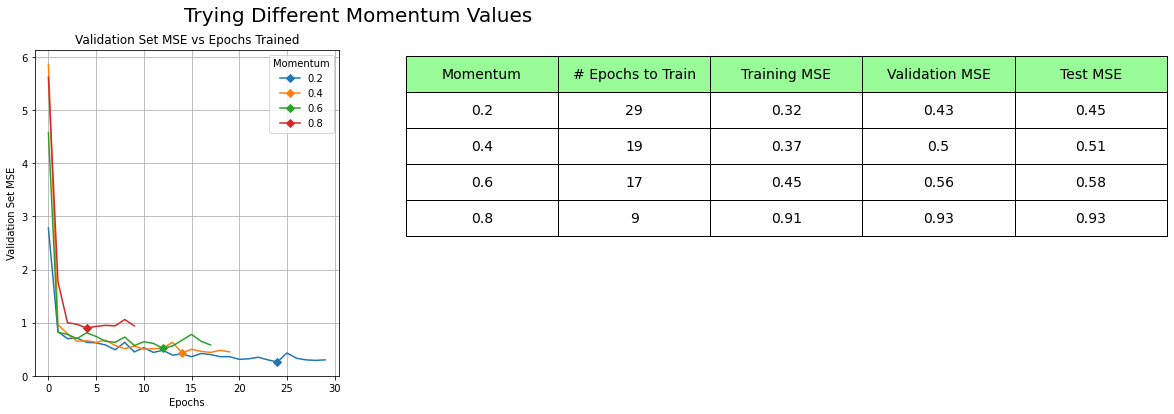

In [383]:
# Train with different momentum values

def mlp(_momentum):
  myMLP_vowel = MLP(lr=0.8, momentum=_momentum, shuffle=True, hidden_layer_widths=[32])
  myMLP_vowel.fit(X_vowel, y_vowel_one_hot, train_test_ratio=0.75, train_validation_ratio=0.85)
  tr_mse = np.transpose(myMLP_vowel.get_training_MSE_data())
  v_mse = np.transpose(myMLP_vowel.get_validation_MSE_data())
  te_mse = np.transpose(myMLP_vowel.get_test_MSE_data())
  return myMLP_vowel.get_epochs_count(), tr_mse[1][-5], v_mse[0][:], v_mse[1][:], te_mse[1][-5]

col_headers = ["Momentum", "# Epochs to Train", "Training MSE", "Validation MSE", "Test MSE"]
table_data = []

multi, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6))
multi.suptitle("Trying Different Momentum Values", fontsize=20)
momentums = [0.2, 0.4, 0.6, 0.8]
for m in momentums:
  e_count, tr_mse, v_mse_x, v_mse_y, te_mse, = mlp(m)
  
  table_data.append([m, e_count, tr_mse, v_mse_y[-5], te_mse])
  ax[0].plot(v_mse_x, v_mse_y, '-D', markevery=[np.argmin(v_mse_y)], label=m)

ax[0].legend(title="Momentum", loc="upper right")
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Validation Set MSE')
ax[0].title.set_text("Validation Set MSE vs Epochs Trained")
ax[0].grid(True)
ax[0].set_ylim(bottom=0)
ax[1].set_axis_off()
table = ax[1].table( cellText = table_data, colLabels = col_headers, colWidths=[0.5]*5, colColours =["palegreen"] * 5, cellLoc ='center', loc ='upper left')
table.set_fontsize(15)
table.scale(1,3)
plt.show()

*Discuss the effect of different momentum values from your graph and table*

It appears that the closer to 0 that momentum gets, the better the final validation MSE that is achieved. Of the the four momentum values tested here (0.2, 0.4, 0.6, 0.8), 0.8 ended with the worst MSE of 0.93, although it was the fastest to bottoming out. 0.2 was the slowest, taking nearly 30 epochs to bottom out, but it acheived the lowest validation MSE (0.43) of any of the other momentum values. 0.4 and 0.6 were nearly identical in speed and final MSE, falling almost perfectly between the metrics of 0.2 and 0.8.

## 4. Scikit-learn Classifier and Comparison

### 4.1 (10%) Use the scikit-learn (SK) version of the MLP classifier on the Iris data set and one data set of your choice.  

You do not need to go through all the steps above, nor graph results. Compare results (accuracy and learning speed) between your version and theirs for some selection of hyper-parameters. Try some different hyper-parameters and comment on their effect.

At a minimum, try

- number of hidden nodes and layers
- different activation functions
- learning rate
- regularization and parameters
- momentum (and try nesterov)
- early stopping

In [395]:
# Load sklearn MLP
skl = MLPClassifier( hidden_layer_sizes=(20,20,20), learning_rate='adaptive', learning_rate_init=0.01, alpha=0.0001, momentum=0.9, nesterovs_momentum=True, early_stopping=True)
# Train on Iris and one other data set
skl.fit(X_iris, y_iris_one_hot)
print("Iris Accuracy:",skl.score(X_iris, y_iris_one_hot))
print("Iris Learning Epochs:",skl.n_iter_)

skl.fit(X_eval, y_eval_one_hot)
print("Eval Accuracy:",skl.score(X_eval, y_eval_one_hot))
print("Eval Learning Epochs:",skl.n_iter_)

Iris Accuracy: 0.96
Iris Learning Epochs: 34
Eval Accuracy: 0.9963556851311953
Eval Learning Epochs: 14


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


*Discussion*

Nesterov's momentum appears to make the model learn faster, as does increasing learning rate and adaptive learning rate (as expected). I was not able to tell significant differences in speed or accuracy between relu, logistic or tanh as activation functions. A pattern was difficult to nail down for hidden layers and node counts, as scaling in and out in either direction had varying results. Higher regularization (alpha) increased the time required to learn data somewhat. For whatever reason, the scikit learn MLP achieved higher accuracies on the Iris dataset than my model did on.

### 4.2 (5%) Using the Iris Dataset automatically adjust hyper-parameters using your choice of grid or random search
- Use a grid or random search approach across a reasonable subset of hyper-parameters from the above 
- Report your best accuracy and hyper-parameters. 

In [12]:
# Load sklearn MLP
stopping = [True, False]
nodes = [8, 20, 32]
learning = ["constant", "adaptive"]
regularization = [0.0001, 0.001, 0.01, 0.1]
nesterovs = [True, False]
momentums = [0.01, 0.05, 0.1, 0.15]

best_stopping = stopping[0]
best_node_c = nodes[0]
best_learning = learning[0]
best_regularization = regularization[0]
best_nesterovs = nesterovs[0]
best_momentum = momentums[0]
best_accuracy_so_far = 0

for stop in stopping:
  skl = MLPClassifier( hidden_layer_sizes=(best_node_c), learning_rate=best_learning, alpha=best_regularization, momentum=best_momentum, nesterovs_momentum=best_nesterovs, early_stopping=stop)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_stopping = stop

for node_c in nodes:
  skl = MLPClassifier( hidden_layer_sizes=(node_c), learning_rate=best_learning, alpha=best_regularization, momentum=best_momentum, nesterovs_momentum=best_nesterovs, early_stopping=best_stopping)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_node_c = node_c

for learn in learning:
  skl = MLPClassifier( hidden_layer_sizes=(best_node_c), learning_rate=learn, alpha=best_regularization, momentum=best_momentum, nesterovs_momentum=best_nesterovs, early_stopping=best_stopping)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_learning = learn

for reg in regularization:
  skl = MLPClassifier( hidden_layer_sizes=(best_node_c), learning_rate=best_learning, alpha=reg, momentum=best_momentum, nesterovs_momentum=best_nesterovs, early_stopping=best_stopping)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_regularization = reg

for nest in nesterovs:
  skl = MLPClassifier( hidden_layer_sizes=(best_node_c), learning_rate=best_learning, alpha=best_regularization, momentum=best_momentum, nesterovs_momentum=nest, early_stopping=best_stopping)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_nesterovs = nest

for momentum in momentums:
  skl = MLPClassifier( hidden_layer_sizes=(best_node_c), learning_rate=best_learning, alpha=best_regularization, momentum=momentum, nesterovs_momentum=best_nesterovs, early_stopping=best_stopping)
  skl.fit(X_iris, y_iris_one_hot)
  score = skl.score(X_iris, y_iris_one_hot)
  if score > best_accuracy_so_far:
    best_accuracy_so_far = score
    best_momentum = momentum

print("\nAccuracy",best_accuracy_so_far,"\n")
print("Best Early Stopping:",best_stopping)
print("Best Hidden Node Count:",best_node_c)
print("Best Learning Scheme:",best_learning)
print("Best Regularization:",best_regularization)
print("Best Nesterovs:",best_nesterovs)
print("Best Momentum:",best_momentum)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py


Accuracy 0.6933333333333334 

Best Early Stopping: False
Best Hidden Node Count: 32
Best Learning Scheme: constant
Best Regularization: 0.0001
Best Nesterovs: True
Best Momentum: 0.01


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


*Discussion*

The accuracy achieved through my grid search was not phenomenal (typically around 67%) on the Iris dataset, but of the hyperparameter space that it was provided, these should be the optimal arangement. A possible hole in this methodology is that any higher-order connections or patterns between the hyperparameters that I tested on are likely to be missed, as the grid search only optimizes in one direction at a time and does not loop back on itself.